In [1]:
# import Dependencies
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# ls dataset dir
covid_dir = os.path.join('./data/train/covid/')
non_covid_dir = os.path.join('./data/train/non-covid/')

print('total training covid images:', len(os.listdir(covid_dir)))
print('total training normal images:', len(os.listdir(non_covid_dir)))

total training covid images: 1896
total training normal images: 1752


In [3]:
#generate train and validation dataset
TRAIN_DIR="data/train/"
TEST_DIR="data/test/"
IMAGE_SIZE=224
DIM=3
EPOCHS=50
BS=16

training_datagen=ImageDataGenerator(rescale=1./255,
                                    rotation_range=15,
                                    shear_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
validation_datagen=ImageDataGenerator(rescale=1./255)

train_gen=training_datagen.flow_from_directory(directory=TRAIN_DIR,
                                              target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                              batch_size=BS,
                                              class_mode='binary',
                                              shuffle=True)
validation_gen=validation_datagen.flow_from_directory(directory=TEST_DIR,
                                                      target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                      batch_size=BS,
                                                      class_mode='binary',
                                                      shuffle=False)

Found 3648 images belonging to 2 classes.
Found 825 images belonging to 2 classes.


In [4]:
train_gen.class_indices

{'covid': 0, 'non-covid': 1}

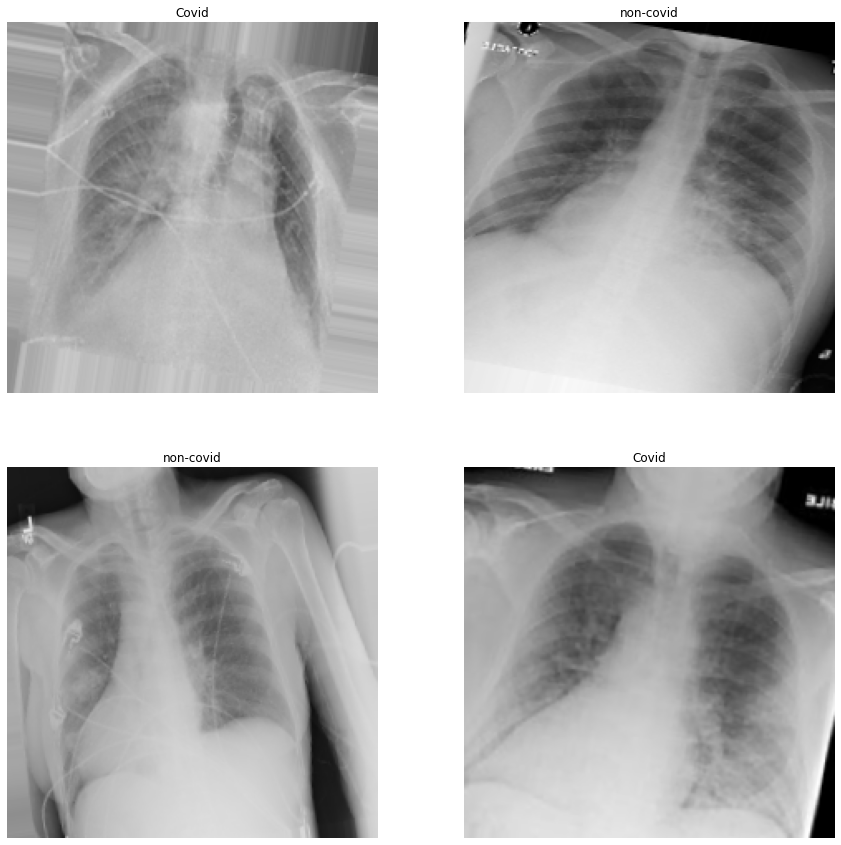

In [7]:
# plot some samples
plt.figure(figsize=(15, 15))
for i in range(4):
    plt.subplot(2,2, i+1)
    img, label = train_gen.next()
    plt.imshow(img[0], cmap='gray')
    dict = {0:'Covid', 1:'non-covid'}
    plt.title(dict[label[0]])
    plt.axis('off')
plt.show()

In [16]:
baseModel=VGG16(weights="imagenet",include_top=False,
                 input_tensor=Input(shape=(IMAGE_SIZE,IMAGE_SIZE,DIM)) )
for layer in baseModel.layers:
    layer.trainable=False

In [17]:
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(2,2))(headModel)
headModel=Flatten(name="flatten")(headModel)
headModel=Dense(128,activation="relu")(headModel)
headModel=Dropout(0.25)(headModel)
headModel=Dense(64,activation="relu")(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(1,activation="sigmoid")(headModel)

model=Model(inputs=baseModel.input,outputs=headModel)

In [18]:
opt=Adam(learning_rate=0.001)

In [19]:
model.compile(loss="binary_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

In [20]:
H = model.fit(train_gen,
              steps_per_epoch=train_gen.samples // BS,
              epochs=EPOCHS,
              validation_data = validation_gen,
              validation_steps=validation_gen.samples // BS,
              verbose = 1)

Epoch 1/50
228/228 [==============================] - 61s 251ms/step - loss: 0.6086 - accuracy: 0.6650 - val_loss: 0.4759 - val_accuracy: 0.8088
Epoch 2/50
228/228 [==============================] - 59s 259ms/step - loss: 0.4964 - accuracy: 0.7645 - val_loss: 0.3951 - val_accuracy: 0.8297
Epoch 3/50
228/228 [==============================] - 61s 266ms/step - loss: 0.4276 - accuracy: 0.8059 - val_loss: 0.4013 - val_accuracy: 0.8211
Epoch 4/50
228/228 [==============================] - 61s 268ms/step - loss: 0.3967 - accuracy: 0.8270 - val_loss: 0.3487 - val_accuracy: 0.8505
Epoch 5/50
228/228 [==============================] - 61s 267ms/step - loss: 0.3858 - accuracy: 0.8300 - val_loss: 0.3558 - val_accuracy: 0.8370
Epoch 6/50
228/228 [==============================] - 60s 263ms/step - loss: 0.3878 - accuracy: 0.8295 - val_loss: 0.5239 - val_accuracy: 0.8015
Epoch 7/50
228/228 [==============================] - 59s 260ms/step - loss: 0.3672 - accuracy: 0.8372 - val_loss: 0.3877 - val_ac

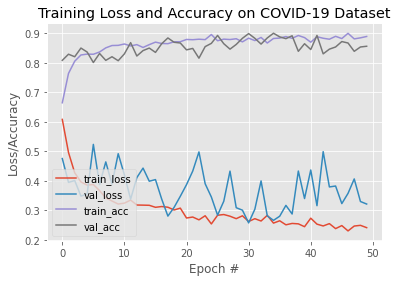

In [21]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [22]:
model.save("model.h5")

In [8]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [34]:
model=load_model("model.h5")
val_predict = model.predict(validation_gen)

In [51]:
predict_class = ((val_predict > 0.5)+0).ravel() 
predict_class = predict_class.tolist()

In [52]:
labels = ['Covid', 'Non-Covid']
report = classification_report(validation_gen.classes, predict_class, target_names=labels)
print(report)

              precision    recall  f1-score   support

       Covid       0.96      0.74      0.84       408
   Non-Covid       0.79      0.97      0.87       417

    accuracy                           0.86       825
   macro avg       0.88      0.86      0.86       825
weighted avg       0.88      0.86      0.86       825



In [53]:
cm = confusion_matrix(validation_gen.classes, predict_class)
cm_df = pd.DataFrame(cm,
                     index = ['COVID','Non-Covid'], 
                     columns = ['COVID','Non-Covid'])

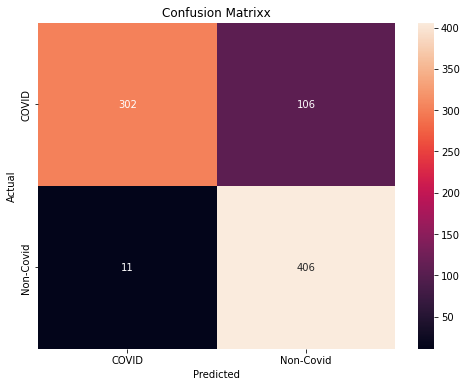

In [54]:
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title("Confusion Matrixx")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

0


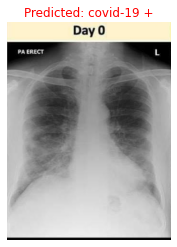

In [39]:
from keras.preprocessing import image
import matplotlib.image as mpimg

img = image.load_img("./samples/covid-19/1.jpg", target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
model=load_model("model.h5")
pred = model.predict(x, batch_size=10)
pred=np.argmax(pred)
print(pred)
predicted_class="covid-19 -" if pred else "covid-19 +"
t_color= "green" if pred else "red"
img = mpimg.imread("./samples/Covid-19/1.jpg")
plt.imshow(img)
plt.axis('Off')
plt.title("Predicted: {}".format(predicted_class),color=t_color)
plt.show()
